In [1]:
import os
import yaml
from pathlib import Path


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import cartopy.crs as ccrs



from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from torch import utils
# import pytorch_lightning as pl
import lightning.pytorch as pl

import model.StNN_index as stnn_index
import model.StNN_static as stnn

from utils import statics_from_config
from dataset.datasets_wrapped import TransferData, WeatherDataset
from utils_data import generate_clim_pred, load_data
from plot_utils import *
import utils_evaluation as eval




In [2]:
import matplotlib as mpl
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn')


/tmp/ipykernel_68221/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Model and Prediction Function

# Results

In [4]:
# Set hyperparameters.
arch_type = 'Index_LSTM' # 'LSTM' # 'ViT'
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf']  #762a83
regimes = ['SB', 'NAO-', 'AR', 'NAO+']
if arch_type == 'ViT':

        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch}'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)


        base_dir = config['base_dir']
        lr_dir = config['lr_dir']

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
        
elif arch_type == 'LSTM':
        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
else:
        cfile = '_1980_index'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)

        config_base = yaml.load(open(f'./config/convlstm_config_1980_olr.yaml'), Loader=yaml.FullLoader)

        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        if '_9cat' in config['var_comb']['input'][0]:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}_9cat/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}_9cat/'
        else:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)
        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn_index.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'

test_loader, data_set, cls_wt, test_set, infos = load_data(config)

var_comb = config['var_comb']

data_info, _ = statics_from_config(config)

seasons =  {'train':{config['data']['dataset_name2']:list(range(config['data']['fine']['train_start'], config['data']['fine']['train_end']))},
'val':{config['data']['dataset_name2']:list(range(config['data']['fine']['val_start'], config['data']['fine']['val_end']))},
'test':{config['data']['dataset_name2']:list(range(config['data']['fine']['test_start'], config['data']['fine']['test_end']))}}

~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


In [5]:
# Load collected data.
exp_dir =  f"{stat_dir}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/"
pths = [xs for xs in Path(exp_dir).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}_temp_scale.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model_temp_scale.npz')
else:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model.npz')
    
persistance = data_collect['persistance'] 
sst = data_collect['sst'] 
u10 = data_collect['u10'] 
dates = data_collect['dates'] 
daytimes = data_collect['daytimes']
loop_probabilities = data_collect['loop_probabilities']
loop_classes = data_collect['loop_classes']
predictions_baseline = data_collect['predictions_baseline']
targets = data_collect['targets']


# results = data_result['results']

In [6]:
input_reg = []
for input, output, weeks, days in data_set:
    if arch_type == 'Index_LSTM':
        input_reg.append(input[1][None,:,-4:].numpy().squeeze())
    else:
        input_reg.append(np.array(input[1]).squeeze())


input_reg = np.concatenate(input_reg).reshape((predictions_baseline.shape[0],
                                                           predictions_baseline.shape[1],4))

In [7]:
# load climatology
smoothing = 7
num_m = 14
dtset_name = config['data']['dataset_name2']

clim_prob = xr.load_dataarray(f'/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/{dtset_name}/climatology/NAE_{num_m}eofs_prob_{smoothing}days_climatology_1980_2009.nc')
predictions_clim = generate_clim_pred(clim_prob, dates)
predictions_clim_classes = np.argmax(predictions_clim, 2)

### All confidences

In [8]:
true_labels = targets.flatten()
lp_pr = loop_probabilities.reshape(loop_classes.shape[0],loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])

confidences = np.zeros((loop_classes.shape[0],loop_classes.shape[1],loop_classes.shape[2]))
num_preds = loop_classes.shape[0]*loop_classes.shape[1]
for k in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for i in range(loop_probabilities.shape[2]):
            confidences[k,j,i] = loop_probabilities[k, j, i, targets[j,i]]

In [9]:
loop_targets = np.repeat(targets[None,:,:], loop_classes.shape[0], axis = 0)
confidences_flat = confidences.flatten()
lp_conf = loop_probabilities.flatten()
q_all, q_90 = 85, 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
targ_all_90 = []
acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    if l == loop_targets[i,j,k]:
                        acc_count +=1
                    all_count +=1
                    conf_all_90.append(loop_probabilities[i,j,k,l])

                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])
print(acc_count/all_count)
conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)

0.2608580997336568


## Skill analysis

### Averaged Brier skill score

In [10]:
# Build loop baselines

loop_clim = np.repeat(predictions_clim, loop_classes.shape[0],axis=0)
loop_u10 = np.repeat(u10[None,...], loop_classes.shape[0],axis=0)
loop_sst = np.repeat(sst[None,...], loop_classes.shape[0],axis=0)
loop_tgs = loop_targets.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_cls = loop_classes.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_prbs = loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2],loop_probabilities.shape[3])

loop_hps= loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_clims = loop_clim.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_tgss = loop_targets.flatten()[confidences_flat>q_90]


## Index Comparison

In [11]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
mjo_index = np.load(f'{index_path}/MJO_index_1980-2023_mjo_testset.npz')
pv_index = np.load(f'{index_path}/pv_index_1980-2023_spv_testset.npz')

mjo_index_in = mjo_index['input']
mjo_index_out = mjo_index['output']
daytimes = mjo_index['daytimes']
dates = mjo_index['dates']

pv_index_in = pv_index['input']
pv_index_out = pv_index['output']

In [12]:
pv_inputs = np.repeat(pv_index_in[None,:,:], loop_classes.shape[0], axis = 0)
pv_outputs = np.repeat(pv_index_out[None,:,:], loop_classes.shape[0], axis = 0)
mjo_inputs = np.repeat(mjo_index_in[None,:,:], loop_classes.shape[0], axis = 0)
mjo_outputs = np.repeat(mjo_index_out[None,:,:], loop_classes.shape[0], axis = 0)

In [13]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
ts_all_90 = []
targ_all_90 = []
pv_all_90 = []
mjo_all_90 = []

acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    conf_all_90.append(loop_probabilities[i,j,k,l])
                    pv_all_90.append(pv_inputs[i,j,:])
                    mjo_all_90.append(mjo_inputs[i,j,:])
                    ts_all_90.append(f'lead week {k+1}')
                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])

conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)
pv_all_90 = np.array(pv_all_90)
mjo_all_90 = np.array(mjo_all_90)


In [14]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)

input_reg_prob = input_reg
input_reg = np.argmax(input_reg, axis = 2)
# regimes = ['SB', 'NAO-', 'NAO+', 'AR']

occ_mjo = np.zeros((4,8))
cnts_reg_in = np.zeros((4,))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):

            if not np.isnan(mjo_inputs[i,j,k]):
                cnts_reg_in[loop_targets[i,j,k]] += 1
                occ_mjo[loop_targets[i,j,k], int(mjo_inputs[i,j,k])-1] += 1


unq_reg, cnts_reg = np.unique(targ_all_90, return_counts=True)
# unq_reg_in, cnts_reg_in = np.unique(input_reg, return_counts=True)
unq_reg_pred, cnts_reg_pred = np.unique(loop_classes, return_counts=True)
unq_mjo, cnts_mjo = np.unique(mjo_all_90, return_counts=True)
cnts_mjo = cnts_mjo[:8]
pred_reg = cnts_reg_pred/cnts_reg_pred.sum()
clim_occ_mjo = occ_mjo/np.repeat(cnts_reg_in[:,None],8,axis=1)

In [15]:
np.savez(f'{results_directory}{arch_type}mjo_spv_teleconnections.npz', conf_all_90 = conf_all_90, pred_all_90 = pred_all_90,
         targ_all_90 = targ_all_90, pv_all_90 = pv_all_90, mjo_all_90 = mjo_all_90)


In [16]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        # d_t = np.abs((t-5)) + (k+1)
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

### MJO index anomalies per regime and time lag in percent

In [17]:
t_in, t_out = mjo_inputs.shape[2],loop_probabilities.shape[2]
mjo_reg_dt = np.zeros((4,8,t_in +t_out-1))
reg_dt = np.zeros((4,t_in +t_out-1))

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(mjo_inputs[i,j,k]):

                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                        d_t = np.abs((t-5)) + (k+1)
                        reg_dt[loop_targets[i,j,k], d_t-1] += 1
                        mjo_reg_dt[loop_targets[i,j,k],int(mjo_inputs[i,j,k])-1, d_t-1] += 1

mjo_reg_dt = mjo_reg_dt/np.repeat(reg_dt[:,None,:],8 ,axis =1)

relative_mjo_reg_dt = mjo_reg_dt - np.repeat(clim_occ_mjo[:,:,None],t_in +t_out-1, axis =2)

/tmp/ipykernel_68221/2407107751.py:16: RuntimeWarning: invalid value encountered in divide
  mjo_reg_dt = mjo_reg_dt/np.repeat(reg_dt[:,None,:],8 ,axis =1)


In [18]:
## Climatology and anomalies of mjo phase number

# regimes = ['SB', 'NAO-', 'NAO+', 'AR']
reg_prob = pred_reg#np.array([0.24,0.19,0.3,0.27])


occ_mjo_90 = np.zeros((loop_probabilities.shape[2],pv_inputs.shape[2],len(regimes),int(unq_mjo[7])))
occ_mjo_reg = np.zeros((4,8))

for r, reg in enumerate(regimes):
    for k in range(loop_probabilities.shape[2]):
        inp_wk = []
        for i in range(loop_probabilities.shape[0]):
            for j in range(loop_probabilities.shape[1]): 
                for t in range(pv_inputs.shape[2]):
                    if r == loop_targets[i,j,k]:
                        if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                            inp_wk.append(f'input week {t-5}')
                        # mjo anomalies
                        if not np.isnan(mjo_inputs[i,j,t]):
                            occ_mjo_reg[r, int(mjo_inputs[i,j,t])-1] += 1
                            if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                                occ_mjo_90[k,t,r,int(mjo_inputs[i,j,t])-1] += 1
  

regime_clim = np.tile(reg_prob, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)
pred_regime_clim = np.tile(pred_reg, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)
mjo_anomalies_90 = (occ_mjo_90/np.repeat(occ_mjo_90.sum(axis = 2)[:,:,None,:],len(regimes), axis=2)) - regime_clim


/tmp/ipykernel_68221/1252906143.py:28: RuntimeWarning: invalid value encountered in divide
  mjo_anomalies_90 = (occ_mjo_90/np.repeat(occ_mjo_90.sum(axis = 2)[:,:,None,:],len(regimes), axis=2)) - regime_clim


#### Plots

In [19]:
cm_list = sns.color_palette("colorblind")
sns.set_palette("colorblind")

data_mjo = {}
# data_mjo['mjo index'] = mjo_all_90
data_mjo['regimes'] = pred_all_90
data_mjo['lead weeks'] = ts_all_90

# data_mjo = pd.DataFrame.from_dict(data_mjo)

data_pv = {}
# data_pv['pv index'] = pv_all_90
data_pv['regimes'] = pred_all_90
data_pv['lead weeks'] = ts_all_90

# data_pv = pd.DataFrame.from_dict(data_pv)

### Delta-t Plot

In [20]:
# regimes = ['SB', 'NAO-', 'AR', 'NAO+']
mjo_strct = {'phase number':[],'delta t': []}
delta_t_mjo = {reg: mjo_strct for reg in regimes}


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                    delta_t = np.abs((t-5)) + (k+1)
                
                    delta_t_mjo[regimes[loop_targets[i,j,k]]]['phase number'].append(mjo_inputs[i,j,t])
                    delta_t_mjo[regimes[loop_targets[i,j,k]]]['delta t'].append(delta_t)
            


In [21]:
# mjo_strct = {'delta t': []}
mjo_strct = {mj: [] for mj in np.arange(1,int(unq_mjo[7])+1)}
mjo_strct['delta t'] = np.unique(np.array(delta_t_mjo[regimes[0]]['delta t']))
delta_t_mjo_map = {reg: mjo_strct for reg in regimes}

# delta_phase = np.zeros(len(np.unique(np.array(delta_t_mjo[regimes[0]]['delta t']))))

for r, reg in enumerate(regimes):
    for p in range(int(unq_mjo[7])):

        delta_t_mjo_map[reg][p+1] = relative_mjo_reg_dt[r, p, :]



In [22]:
# # conditional probabilities.
# frac = 0.8
# t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]
# sampled_cassous_ls = []
# for mod in range(loop_probabilities.shape[0]): 
#     sub_indx = np.random.choice(np.arange(loop_probabilities.shape[0]), 
#                                 size = int(frac*loop_probabilities.shape[0]), replace = False)
#     sub_mjo = mjo_inputs[sub_indx,...]
#     sub_lp = loop_probabilities[sub_indx,...]
#     sub_targets = loop_targets[sub_indx,...]

#     cassou_conditional_count = np.zeros((4,8,t_in +t_out-1))
#     cassou_unconditional_count = np.zeros((4,t_in +t_out-1))
#     for i in range(sub_lp.shape[0]):
#         for j in range(sub_lp.shape[1]):
#             for k in range(sub_lp.shape[2]):
#                 for t in range(mjo_inputs.shape[2]):
#                     if not np.isnan(mjo_inputs[i,j,k]):
#                         if not qall_90:
#                             d_t = np.abs((t-5)) + (k+1)
#                             cassou_conditional_count[sub_targets[i,j,k], int(mjo_inputs[i,j,t])-1, d_t-1] += 1
#                             cassou_unconditional_count[sub_targets[i,j,k], d_t-1] += 1
#                         else:
#                             if sub_lp[i,j,k,sub_targets[i,j,k]] > qall_90:
#                                 d_t = np.abs((t-5)) + (k+1)
#                                 cassou_conditional_count[sub_targets[i,j,k], int(mjo_inputs[i,j,t])-1, d_t-1] += 1
#                                 cassou_unconditional_count[sub_targets[i,j,k], d_t-1] += 1


#     cassou_conditional_total = np.sum(cassou_conditional_count, axis = 0)
#     cassou_unconditional_total = np.sum(cassou_unconditional_count, axis = 0)
#     cassou_conditional_pc = cassou_conditional_count/np.repeat(cassou_conditional_total[None,:,:],4,axis=0)
#     cassou_unconditional_pc = cassou_unconditional_count/np.repeat(cassou_unconditional_total[None,:],4,axis=0)
            
#     cassou_probability_change = 100 *(cassou_conditional_pc - np.repeat(cassou_unconditional_pc[:,None,:],8,axis=1))

#     sampled_cassous_ls.append(cassou_probability_change[None,...])

# sampled_cassous = np.concatenate(sampled_cassous_ls)

# probability_cassou_ls = []
# probability_cassou_array = np.zeros((4,8,t_in +t_out-1))
# for mjo_phase in range(8):
#     for shift_value in range(t_in +t_out-1):
#         for label in range(4):
#             probability_change = sampled_cassous[:,label,mjo_phase,shift_value]

#             mean = np.nanmean(probability_change)
#             if np.isnan(mean):
#                 mean = 0
#             pc_975 = np.nanpercentile(probability_change ,97.5)
#             pc_025 = np.nanpercentile(probability_change, 2.5)

#             if np.sign(pc_025)==np.sign(pc_975):
#                 significance = 1
#             else:
#                 significance = 0

#             probability_cassou_ls.append(pd.DataFrame(data={
#                 "MJO phase": [mjo_phase+1],
#                 "Lag (weeks)": [shift_value+1],
#                 "label": [label],
#                 "mean": [mean],
#                 "significance": [significance]}))
            
#             probability_cassou_array[label,mjo_phase,shift_value] = mean

# probability_cassou = pd.concat(probability_cassou_ls)

In [23]:
# from matplotlib.patches import Rectangle
# chosen_cluster_number = 4
# vmin = np.abs(np.nanmin(probability_cassou_array))
# vmax = np.nanmax(probability_cassou_array)
# vmax = max([vmin,vmax]) 

# fig, axes = plt.subplots(chosen_cluster_number, 1, figsize=(7, 14))

# for i in range(chosen_cluster_number):

#     plot_data = probability_cassou[probability_cassou['label']==i]
#     plot_data = plot_data[plot_data['MJO phase']!=0]
#     heatmap_data = pd.pivot_table(plot_data, values='mean', index=['MJO phase'], columns='Lag (weeks)')
    
#     g = sns.heatmap(heatmap_data, cmap='RdBu_r', square=False, ax = axes[i], vmin=-vmax, vmax = vmax, cbar_kws={'label': 'relative frequency [%]'})
#     g.set_title(f'{regimes[i]} regime')
#     for index, row in plot_data[plot_data['significance'] == 1].iterrows():
#         name_pos = heatmap_data.index.get_loc(row['MJO phase'])
#         id_pos = heatmap_data.columns.get_loc(row['Lag (weeks)'])
#         # g.add_patch(Rectangle((id_pos, name_pos), 1, 1, ec='black', fc='none', lw=1))
        
# # fig.suptitle('PCA + k-means regimes', fontsize=14, x=0.45, y=0.99)
# plt.tight_layout()

In [24]:
# fig, axes = plt.subplots(1, len(regimes), figsize=(20,5))#, sharex = True)

# delta_t = np.unique(np.array(delta_t_mjo[regimes[0]]['delta t']))
# mjo_ind = np.arange(1,int(unq_mjo[7])+1)
# vmin = np.abs(np.min(probability_cassou_array))
# vmax = np.max(probability_cassou_array)
# vmax = max([vmin,vmax]) 

# # for i, (keys, plot_val_mjo) in enumerate(delta_t_mjo.items()):
# for r in range(probability_cassou_array.shape[0]):

#     keys = regimes[r]
#     cbar_flag = True if r == len(regimes)-1 else False
#     ax = axes[r]

#     im = ax.imshow(probability_cassou_array[r, :, :], cmap = 'seismic', vmin=-vmax, vmax=vmax, interpolation='nearest')#, cbar=cbar_flag, cbar_ax=axes[-1],)
#     if r == 0:
#         ax.set_ylabel(f'mjo phase')
#     ax.set_xlabel(f'delta t [weeks]')

#     ax.set_xticks(range(len(delta_t)), labels=delta_t,
#               rotation=45, ha="right", rotation_mode="anchor")
#     ax.set_yticks(range(len(mjo_ind)), labels=mjo_ind)
    

#     ax.set_title(f'{keys}')
    
# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.6])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.ax.set_ylabel('relative frequency [%]', rotation=-90, va="bottom")

# fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_probability_mjoPhase.png", dpi=600, bbox_inches='tight')

## MJO Phase plots

In [25]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
rmm1_index = np.load(f'{index_path}/rmm1_index_1980-2023_mjo_testset.npz')
rmm2_index = np.load(f'{index_path}/rmm2_index_1980-2023_mjo_testset.npz')

rmm1_index_in = rmm1_index['input']
rmm1_index_out = rmm1_index['output']
daytimes = rmm1_index['daytimes']
dates = rmm1_index['dates']

rmm2_index_in = rmm2_index['input']
rmm2_index_out = rmm2_index['output']
rmm2_inputs = np.repeat(rmm2_index_in[None,:,:], loop_classes.shape[0], axis = 0)
rmm2_outputs = np.repeat(rmm2_index_out[None,:,:], loop_classes.shape[0], axis = 0)
rmm1_inputs = np.repeat(rmm1_index_in[None,:,:], loop_classes.shape[0], axis = 0)
rmm1_outputs = np.repeat(rmm1_index_out[None,:,:], loop_classes.shape[0], axis = 0)

In [26]:
sum_rmm1_reg = np.zeros((4,1))
sum_rmm2_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(rmm1_inputs.shape[2]):
                if not np.isnan(rmm1_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_rmm1_reg[input_reg[j,k]] += rmm1_inputs[i,j,t]
                    sum_rmm2_reg[input_reg[j,k]] += rmm2_inputs[i,j,t]

avg_rmm1 = (sum_rmm1_reg.T/cnts_reg_in).flatten()
avg_rmm2 = (sum_rmm2_reg.T/cnts_reg_in).flatten()


rmm1_anomalies = np.zeros(rmm1_inputs.shape)
rmm2_anomalies = np.zeros(rmm1_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(rmm1_inputs.shape[2]):
                    if not np.isnan(rmm1_inputs[i,j,t]):
                        # d_t = np.abs((t-5)) + (k+1)
                        rmm1_anomalies[i,j,t] = rmm1_inputs[i,j,t]- avg_rmm1[input_reg[j,k]]
                        rmm2_anomalies[i,j,t] = rmm2_inputs[i,j,t]- avg_rmm2[input_reg[j,k]]

rmm1_anom_reg_dt = []
rmm1_inp_reg_dt = []
rmm2_anom_reg_dt = []
rmm2_inp_reg_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    rmm1_reg_dt = np.zeros((4,t_in +t_out-1))
    rmm1_inp_dt = np.zeros((4,t_in +t_out-1))
    rmm2_reg_dt = np.zeros((4,t_in +t_out-1))
    rmm2_inp_dt = np.zeros((4,t_in +t_out-1))
    cnt_correct_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(rmm1_inputs.shape[2]): #input timesteps
                if not np.isnan(rmm1_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                        d_t = np.abs((t-5)) + (k+1)
                        cnt_correct_dt[loop_targets[i,j,k], d_t-1] += 1
                        rmm1_reg_dt[loop_targets[i,j,k], d_t-1] += rmm1_anomalies[i,j,t]
                        rmm1_inp_dt[loop_targets[i,j,k], d_t-1] += rmm1_inputs[i,j,t]
                        rmm2_reg_dt[loop_targets[i,j,k], d_t-1] += rmm1_anomalies[i,j,t]
                        rmm2_inp_dt[loop_targets[i,j,k], d_t-1] += rmm1_inputs[i,j,t]
    rmm1_anom_reg_dt.append(rmm1_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    rmm1_inp_reg_dt.append(rmm1_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])
    rmm2_anom_reg_dt.append(rmm2_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    rmm2_inp_reg_dt.append(rmm2_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])

rmm1_anom_reg_dt = np.concatenate(rmm1_anom_reg_dt)
rmm1_inp_reg_dt = np.concatenate(rmm1_inp_reg_dt)
rmm2_anom_reg_dt = np.concatenate(rmm2_anom_reg_dt)
rmm2_inp_reg_dt = np.concatenate(rmm2_inp_reg_dt)

/tmp/ipykernel_68221/1645361691.py:53: RuntimeWarning: invalid value encountered in divide
  rmm1_anom_reg_dt.append(rmm1_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_68221/1645361691.py:54: RuntimeWarning: invalid value encountered in divide
  rmm1_inp_reg_dt.append(rmm1_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_68221/1645361691.py:55: RuntimeWarning: invalid value encountered in divide
  rmm2_anom_reg_dt.append(rmm2_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_68221/1645361691.py:56: RuntimeWarning: invalid value encountered in divide
  rmm2_inp_reg_dt.append(rmm2_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])


In [27]:
rmm1_anom_reg_t = []
rmm1_inp_reg_t = []
rmm2_anom_reg_t = []
rmm2_inp_reg_t = []

for i in range(loop_probabilities.shape[0]): # number models
    rmm1_reg_t = np.zeros((4,t_in, t_out))
    rmm1_inp_t = np.zeros((4,t_in, t_out))
    rmm2_reg_t = np.zeros((4,t_in, t_out))
    rmm2_inp_t = np.zeros((4,t_in, t_out))
    cnt_correct_t = np.zeros((4,t_in, t_out))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(rmm1_inputs.shape[2]): #input timesteps
                if not np.isnan(rmm1_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                        cnt_correct_t[loop_targets[i,j,k], k, t] += 1
                        rmm1_reg_t[loop_targets[i,j,k], k, t] += rmm1_anomalies[i,j,t]
                        rmm1_inp_t[loop_targets[i,j,k], k, t] += rmm1_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
                        rmm2_reg_t[loop_targets[i,j,k], k, t] += rmm2_anomalies[i,j,t]
                        rmm2_inp_t[loop_targets[i,j,k], k, t] += rmm2_inputs[i,j,t]
    rmm1_anom_reg_t.append(rmm1_reg_t[None,...]/cnt_correct_t[None,...])
    rmm1_inp_reg_t.append(rmm1_inp_t[None,...]/cnt_correct_t[None,...])
    rmm2_anom_reg_t.append(rmm2_reg_t[None,...]/cnt_correct_t[None,...])
    rmm2_inp_reg_t.append(rmm2_inp_t[None,...]/cnt_correct_t[None,...])

rmm1_anom_reg_t = np.concatenate(rmm1_anom_reg_t) # num models x num classes x num output timesteps x num input timesteps
rmm1_inp_reg_t = np.concatenate(rmm1_inp_reg_t)
rmm2_anom_reg_t = np.concatenate(rmm2_anom_reg_t) # num models x num classes x num output timesteps x num input timesteps
rmm2_inp_reg_t = np.concatenate(rmm2_inp_reg_t)

rmm1_anom_reg_mean = np.nanmean(rmm1_anom_reg_t, axis = 0)
rmm1_anom_reg_std = np.nanstd(rmm1_anom_reg_t, axis = 0)
rmm2_anom_reg_mean = np.nanmean(rmm2_anom_reg_t, axis = 0)
rmm2_anom_reg_std = np.nanstd(rmm1_anom_reg_t, axis = 0)

/tmp/ipykernel_68221/177499213.py:22: RuntimeWarning: invalid value encountered in divide
  rmm1_anom_reg_t.append(rmm1_reg_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_68221/177499213.py:23: RuntimeWarning: invalid value encountered in divide
  rmm1_inp_reg_t.append(rmm1_inp_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_68221/177499213.py:24: RuntimeWarning: invalid value encountered in divide
  rmm2_anom_reg_t.append(rmm2_reg_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_68221/177499213.py:25: RuntimeWarning: invalid value encountered in divide
  rmm2_inp_reg_t.append(rmm2_inp_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_68221/177499213.py:32: RuntimeWarning: Mean of empty slice
  rmm1_anom_reg_mean = np.nanmean(rmm1_anom_reg_t, axis = 0)
/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ip

## Figure 5: MJO

In [28]:
rmm1_anom_tar_dt = []
rmm2_anom_tar_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    rmm1_tar_dt = np.zeros((4,t_in +t_out-1))
    rmm2_tar_dt = np.zeros((4,t_in +t_out-1))
    cnt_tar_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    d_t = np.abs((t-5)) + (k+1)
                    cnt_tar_dt[loop_targets[i,j,k], d_t-1] += 1
                    rmm1_tar_dt[loop_targets[i,j,k], d_t-1] += rmm1_anomalies[i,j,t]
                    rmm2_tar_dt[loop_targets[i,j,k], d_t-1] += rmm2_anomalies[i,j,t]

    rmm1_anom_tar_dt.append(rmm1_tar_dt[None,...]/cnt_tar_dt[None,...])
    rmm2_anom_tar_dt.append(rmm2_tar_dt[None,...]/cnt_tar_dt[None,...])

rmm1_anom_tar_dt = np.concatenate(rmm1_anom_tar_dt)
rmm2_anom_tar_dt = np.concatenate(rmm2_anom_tar_dt)

rmm1_anom_tar_dt_mean = np.nanmean(rmm1_anom_tar_dt, axis = 0)
rmm1_anom_tar_dt_std = np.nanstd(rmm1_anom_tar_dt, axis = 0)
rmm2_anom_tar_dt_mean = np.nanmean(rmm2_anom_tar_dt, axis = 0)
rmm2_anom_tar_dt_std = np.nanstd(rmm2_anom_tar_dt, axis = 0)

In [29]:
rmm1_anom_all_dt = []
rmm2_anom_all_dt = []

for i in range(loop_probabilities.shape[0]): # number models

    rmm1_all_dt = np.zeros((4,t_in +t_out-1))
    rmm2_all_dt = np.zeros((4,t_in +t_out-1))
    cnt_all_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    d_t = np.abs((t-5)) + (k+1)
                    cnt_all_dt[loop_classes[i,j,k], d_t-1] += 1
                    rmm1_all_dt[loop_classes[i,j,k], d_t-1] += rmm1_anomalies[i,j,t]
                    rmm2_all_dt[loop_classes[i,j,k], d_t-1] += rmm2_anomalies[i,j,t]

    rmm1_anom_all_dt.append(rmm1_all_dt[None,...]/cnt_all_dt[None,...])
    rmm2_anom_all_dt.append(rmm2_all_dt[None,...]/cnt_all_dt[None,...])

rmm1_anom_all_dt = np.concatenate(rmm1_anom_all_dt)
rmm2_anom_all_dt = np.concatenate(rmm2_anom_all_dt)
rmm1_anom_all_dt_mean = np.nanmean(rmm1_anom_all_dt, axis = 0)
rmm1_anom_all_dt_std = np.nanstd(rmm1_anom_all_dt, axis = 0)
rmm2_anom_all_dt_mean = np.nanmean(rmm2_anom_all_dt, axis = 0)
rmm2_anom_all_dt_std = np.nanstd(rmm2_anom_all_dt, axis = 0)

/tmp/ipykernel_68221/1086425031.py:18: RuntimeWarning: invalid value encountered in divide
  rmm1_anom_all_dt.append(rmm1_all_dt[None,...]/cnt_all_dt[None,...])
/tmp/ipykernel_68221/1086425031.py:19: RuntimeWarning: invalid value encountered in divide
  rmm2_anom_all_dt.append(rmm2_all_dt[None,...]/cnt_all_dt[None,...])


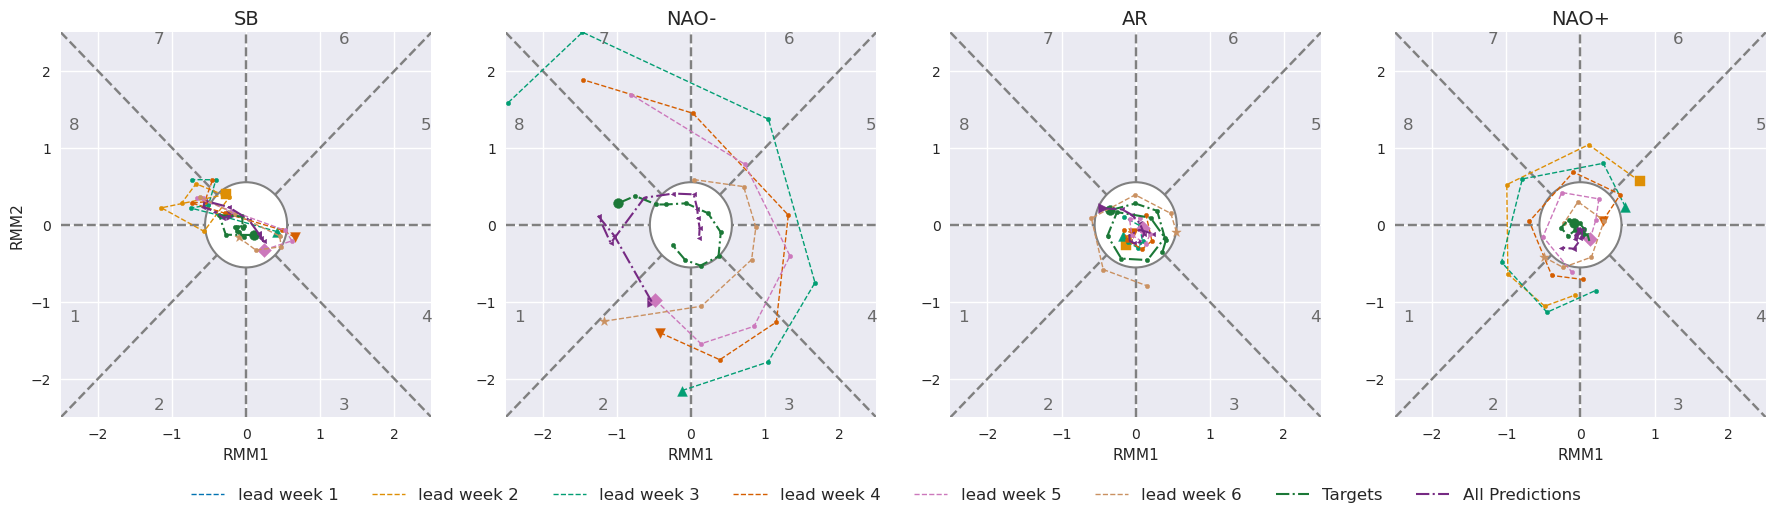

In [30]:
# PLOT MJO
from matplotlib.patches import Circle
fig, axs = plt.subplots(1, len(regimes), figsize=(22, 5))

#=========================
# 
#=========================
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.2,1, 6)
alphas_dt = np.linspace(0.2,1, rmm1_anom_all_dt_mean[r,:].shape[0])
marker_list = ['o','s','^','v','D','*']
# vmax_rmm1 = np.nanmax(np.abs(rmm1_anom_reg_dt[:,:,:].flatten()))
# vmax_rmm2 = np.nanmax(np.abs(rmm2_anom_reg_dt[:,:,:].flatten()))
vmax_rmm1 = 2.5
vmax_rmm2 = 2.5


# amplitude_threshold = np.nanpercentile(np.abs(rmm1_anom_tar_dt_mean.flatten()), 95) #95th percentile of ERA5 values (climatology)
amplitude_threshold = np.nanmean(rmm1_anom_reg_mean) + np.nanstd(rmm1_anom_reg_mean) # 1 std above the mean of the anomalies
# amplitude_threshold = np.nanmean(rmm1_anom_tar_dt_mean) + np.nanstd(rmm1_anom_tar_dt_mean) # 2 std above the mean of the anomalies
# mjo_categories = ["phase1", "phase2","phase3","phase4","phase5","phase6","phase7","phase8", "inactive"]

#====================================================
# plot 1 - MJO Phase Diagram
#====================================================
for r, reg in enumerate(regimes):
    axs[r].set_title(f"{reg}", fontsize=14)

    plot_rmm1 = rmm1_anom_reg_mean[r,:,:]
    plot_rmm2 = rmm2_anom_reg_mean[r,:,:]
    plot_rmm1_std = rmm1_anom_reg_std[r,:,:]
    plot_rmm2_std = rmm2_anom_reg_std[r,:,:]

    plot_all_rmm1 = rmm1_anom_all_dt_mean[r,:]
    plot_all_rmm2 = rmm2_anom_all_dt_mean[r,:]

    plot_tar_rmm1 = rmm1_anom_tar_dt_mean[r,:]
    plot_tar_rmm2 = rmm2_anom_tar_dt_mean[r,:]

    for dt in range(plot_tar_rmm1.shape[0]):
        if dt == 0:
            # axs[r].text(plot_all_rmm1[dt]+0.01, plot_all_rmm2[dt]+0.01, f'dt-{dt+1}', fontsize=10,  color = cm_list[2], weight = 'bold')
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '>',  color = cm_list[2],#label = f'All, dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = 'o',  color = cm_list[1],#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
            # axs[r].text(plot_tar_rmm1[dt]+0.01, plot_tar_rmm2[dt]+0.01, f'dt-{dt+1}', fontsize=10,  color = cm_list[1], weight = 'bold')
        else:
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = cm_list[2],#label = f'All, dt {dt+1}', alpha =alphas[k])
                            s = 10, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = 'o',  color = cm_list[1],#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                            s = 10, zorder = 3)

    for t in range(plot_rmm1.shape[0]):
            
        for k in range(plot_rmm2.shape[1]):
            if k == 0:
                # axs[r].text(plot_rmm1[t,k]+0.01, plot_rmm2[t,k]+0.01, f't-{k-6}', fontsize=10, color = colors[t], weight = 'bold')
                axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = marker_list[t], color = colors[t],#alpha =alphas[k])
                            s = 50, zorder = 3)
            else:
                axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = 'o', color = colors[t],#alpha =alphas[k])
                           s = 10, zorder = 3)

        axs[r].plot(plot_rmm1[t,:], plot_rmm2[t,:], color=colors[t], label = f'lead week {t+1}',#marker = marker_list[t], markersize = 5, #alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder = 3)
        # axs[r].fill_between(plot_rmm1[t,:], plot_rmm2[t,:] - plot_rmm2_std[t,:], 
        #         plot_rmm2[t,:] + plot_rmm2_std[t,:], color=colors[t], alpha=0.2, zorder=3)
        # axs[r].fill_betweenx(plot_rmm1[t,:] - plot_rmm1_std[t,:], plot_rmm1[t,:] - plot_rmm1_std[t,:], plot_rmm2[t,:], 
        #                      color=colors[t], alpha=0.2, zorder=3)
        

    axs[r].plot(plot_tar_rmm1, plot_tar_rmm2, color = cm_list[1], label = 'Targets',linestyle = '-.',#alpha =alphas[k])label = 'ERA5'
                        linewidth=1.5, zorder = 3)
    axs[r].plot(plot_all_rmm1, plot_all_rmm2, color = cm_list[2], label = 'All Predictions',linestyle = '-.',#alpha =alphas[k]) label = 'All'
                        linewidth=1.5, zorder = 3)

    # Set axis labels and limits
    axs[r].set_xlabel('RMM1')
    # axs[r].set_ylabel('RMM2')

    # Add a white circle with radius 0.5
    circlea = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray', facecolor='white', zorder = 2)
    circleb = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray',linewidth=1.5 ,fill = False, zorder = 2)
    axs[r].add_patch(circlea)
    axs[r].add_patch(circleb)


    # Add lines to divide each quadrant and its diagonal
    axs[r].axhline(y=0, color='gray', linestyle='--', zorder = 1)
    axs[r].axvline(x=0, color='gray', linestyle='--', zorder = 1)

    axs[r].plot([-vmax_rmm1, vmax_rmm1], [vmax_rmm2, -vmax_rmm2], color='gray', linestyle='--', zorder = 1)
    axs[r].plot([-vmax_rmm1, vmax_rmm1], [-vmax_rmm2, vmax_rmm2], color='gray', linestyle='--', zorder = 1)

    # center of 8th.
    x_3rd3 =  vmax_rmm1/2 +vmax_rmm1/4
    x_half = vmax_rmm1/2
    y_3rd3 = vmax_rmm2/2 + vmax_rmm2/4
    y_half = vmax_rmm2/2
    axs[r].text(-vmax_rmm1+0.11, -y_half, '1', fontsize=12, color = 'dimgray')
    axs[r].text(-x_half, -vmax_rmm2+0.11, '2', fontsize=12, color = 'dimgray')
    axs[r].text(x_half, -vmax_rmm2+0.11, '3', fontsize=12, color = 'dimgray')
    axs[r].text(vmax_rmm1-0.14, -y_half, '4', fontsize=12, color = 'dimgray')
    axs[r].text(vmax_rmm1-0.14, y_half, '5', fontsize=12, color = 'dimgray')
    axs[r].text(x_half, vmax_rmm2-0.14, '6', fontsize=12, color = 'dimgray')
    axs[r].text(-x_half, vmax_rmm2-0.14, '7', fontsize=12, color = 'dimgray')
    axs[r].text(-vmax_rmm1+0.11, y_half, '8', fontsize=12, color = 'dimgray')

    axs[r].set_xlim([-vmax_rmm1, vmax_rmm1])
    axs[r].set_ylim([-vmax_rmm2, vmax_rmm2])

    # Add a grid
    axs[0].grid()


axs[0].set_ylabel('RMM2')
handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8, fontsize =12)
fig.savefig(f"{results_directory}/MJO_phase_{arch_type}_90thpercentile_V2.png", dpi=600, bbox_inches='tight')

In [31]:
# np.savez(f'{results_directory}{arch_type}mjo_teleconnections.npz', rmm1_anom_reg_mean = rmm1_anom_reg_mean, rmm2_anom_reg_mean = rmm2_anom_reg_mean,
#     rmm1_anom_reg_std = rmm1_anom_reg_std, rmm2_anom_reg_std = rmm2_anom_reg_std, rmm1_anom_all_dt_mean = rmm1_anom_all_dt_mean, rmm2_anom_all_dt_mean = rmm2_anom_all_dt_mean,
#     rmm1_anom_tar_dt_mean = rmm1_anom_tar_dt_mean, rmm2_anom_tar_dt_mean = rmm2_anom_tar_dt_mean, vmax = 2.5, 
#     vmax_rmm2= vmax_rmm2, vmax_rmm1 = vmax_rmm1, regimes = regimes, amplitude_threshold = amplitude_threshold, cm_list = cm_list, 
#     colors = colors, marker_list = marker_list)

## Activ vs Inactive

In [32]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
mjo_cat9_index = np.load(f'{index_path}/MJO_9cat_index_1980-2023_mjo_testset.npz')


mjo_cat9_index_in = mjo_cat9_index['input']
mjo_cat9_in = np.repeat(mjo_cat9_index_in[None,:,:], loop_classes.shape[0], axis = 0)


In [ ]:
inactive_active_mjo = np.zeros((loop_probabilities.shape[0],2,2)) # inactive, active, correct, incorrect

# conditional probabilities.
t_in, t_out = mjo_cat9_in.shape[2],loop_probabilities.shape[2]
for mod in range(loop_probabilities.shape[0]): 
    sub_mjo = mjo_cat9_in[mod,...]
    sub_cl = loop_classes[mod,...]
    sub_targets = loop_targets[mod,...]


    for j in range(sub_cl.shape[0]):
        for k in range(sub_cl.shape[1]):
            for t in range(mjo_inputs.shape[2]):
                if not np.isnan(mjo_inputs[i,j,k]):
                    if sub_cl[j,k] == sub_targets[j,k]:
                        if sub_mjo[j,t] == 0:
                            inactive_active_mjo[mod,0,0] += 1
                        else:
                            inactive_active_mjo[mod,0,1] += 1
                    else:
                        if sub_mjo[j,t] == 0:
                            inactive_active_mjo[mod,1,0] += 1
                        else:
                            inactive_active_mjo[mod,1,1] += 1


inactive_active_mjo = (inactive_active_mjo/mjo_cat9_in.shape[2])/sub_cl.shape[1]
print(np.mean(inactive_active_mjo, axis = 0))
print(np.std(inactive_active_mjo, axis = 0))

[[ 68.70707071  81.81313131]
 [202.29292929 179.18686869]]
[[1.48700712 3.45913204]
 [1.48700712 3.45913204]]


In [ ]:
mean_inact_act = np.mean(inactive_active_mjo, axis = 0)
std_inact_act = np.std(inactive_active_mjo, axis = 0)
print(f'Inctive and correct: {mean_inact_act[0,0]:.2f} +/- {std_inact_act[0,0]:.2f}')
print(f'Inactive and correct: {mean_inact_act[0,1]:.2f} +/- {std_inact_act[0,1]:.2f}')

Active and correct: 68.71 +/- 1.49
Inactive and correct: 81.81 +/- 3.46


In [44]:
np.savez(f'{results_directory}{arch_type}mjo_teleconnections.npz', rmm1_anom_reg_mean = rmm1_anom_reg_mean, rmm2_anom_reg_mean = rmm2_anom_reg_mean,
    rmm1_anom_reg_std = rmm1_anom_reg_std, rmm2_anom_reg_std = rmm2_anom_reg_std, rmm1_anom_all_dt_mean = rmm1_anom_all_dt_mean, rmm2_anom_all_dt_mean = rmm2_anom_all_dt_mean,
    rmm1_anom_tar_dt_mean = rmm1_anom_tar_dt_mean, rmm2_anom_tar_dt_mean = rmm2_anom_tar_dt_mean, vmax = 2.5, alphas = alphas, alphas_dt = alphas_dt,
    vmax_rmm2= vmax_rmm2, vmax_rmm1 = vmax_rmm1, regimes = regimes, amplitude_threshold = amplitude_threshold, cm_list = cm_list, 
    colors = colors, marker_list = marker_list, mean_inact_act = mean_inact_act, std_inact_act = std_inact_act)

## Old plots

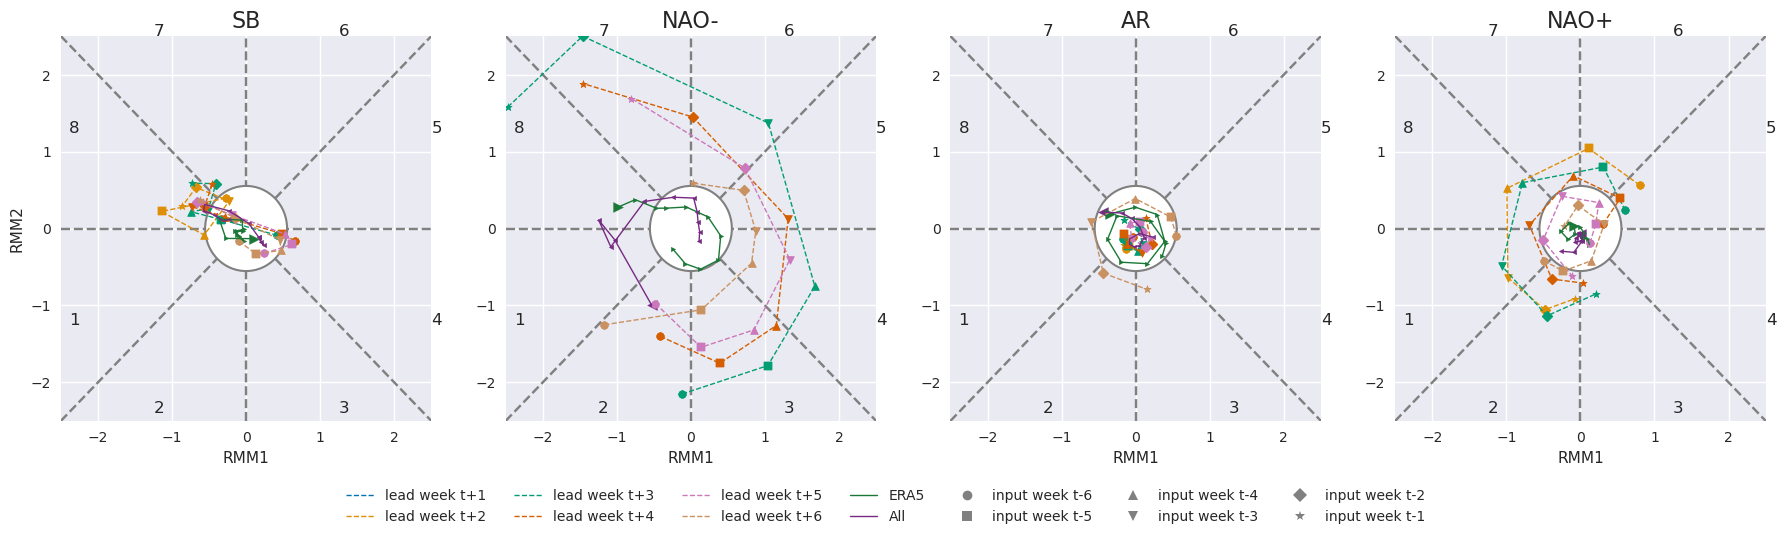

In [36]:
# PLOT MJO
# PLOT MJO
from matplotlib.patches import Circle
fig, axs = plt.subplots(1, len(regimes), figsize=(22, 5))

#=========================
# 
#=========================
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.2,1, 6)
alphas_dt = np.linspace(0.2,1, rmm1_anom_all_dt_mean[r,:].shape[0])
marker_list = ["o","s","^","v","D","*"]
vmax_rmm1 = np.nanmax(np.abs(rmm1_anom_reg_dt[:,:,:].flatten()))
vmax_rmm2 = np.nanmax(np.abs(rmm2_anom_reg_dt[:,:,:].flatten()))


# amplitude_threshold = np.nanpercentile(np.abs(rmm1_anom_reg_dt[:,:,:].flatten()), 60)
amplitude_threshold =  np.nanmean(rmm1_anom_reg_mean) + np.nanstd(rmm1_anom_reg_mean)
mjo_categories = ["phase1", "phase2","phase3","phase4","phase5","phase6","phase7","phase8", "inactive"]

labels_col = []
#====================================================
# plot 1 - MJO Phase Diagram
#====================================================
for r, reg in enumerate(regimes):
    axs[r].set_title(f"{reg}", fontsize = 16)

    plot_rmm1 = rmm1_anom_reg_mean[r,:,:]
    plot_rmm2 = rmm2_anom_reg_mean[r,:,:]

    plot_all_rmm1 = rmm1_anom_all_dt_mean[r,:]
    plot_all_rmm2 = rmm2_anom_all_dt_mean[r,:]

    plot_tar_rmm1 = rmm1_anom_tar_dt_mean[r,:]
    plot_tar_rmm2 = rmm2_anom_tar_dt_mean[r,:]

    for dt in range(plot_tar_rmm1.shape[0]):
        if dt == 0:
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = cm_list[2],#label = f'All, dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = '>',  color = cm_list[1],#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
        else:
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = cm_list[2],#label = f'All, dt {dt+1}', alpha =alphas[k])
                            s = 10, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = '>',  color = cm_list[1],#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                            s = 10, zorder = 3)

    for t in range(plot_rmm1.shape[0]):
            
        for k in range(plot_rmm2.shape[1]):
            if t == 0 and r==0:
                labels_col.append(f'input week t{k-6}')
            axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = marker_list[k], color = colors[t],#alpha =alphas[k])
                           s = 30, zorder = 3)
            axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = marker_list[k], color = colors[t],#alpha =alphas[k])
                           s = 30, zorder = 3)

        axs[r].plot(plot_rmm1[t,:], plot_rmm2[t,:], color=colors[t], label = f'lead week t+{t+1}', #marker = marker_list[t], markersize = 5, #alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder = 3)
    axs[r].plot(plot_tar_rmm1, plot_tar_rmm2, color = cm_list[1], label = 'ERA5',#alpha =alphas[k])
                        linewidth=1, zorder = 3)
    axs[r].plot(plot_all_rmm1, plot_all_rmm2, color = cm_list[2], label = 'All',#alpha =alphas[k])
                        linewidth=1, zorder = 3)

    # Set axis labels and limits
    axs[r].set_xlabel('RMM1')
    # axs[r].set_ylabel('RMM2')

    # Add a white circle with radius 0.5
    circlea = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray', facecolor='white', zorder = 2)
    circleb = Circle((0, 0), radius=amplitude_threshold, edgecolor='gray',linewidth=1.5 ,fill = False, zorder = 2)
    axs[r].add_patch(circlea)
    axs[r].add_patch(circleb)


    # Add lines to divide each quadrant and its diagonal
    axs[r].axhline(y=0, color='gray', linestyle='--', zorder = 1)
    axs[r].axvline(x=0, color='gray', linestyle='--', zorder = 1)

    axs[r].plot([-vmax_rmm1, vmax_rmm1], [vmax_rmm2, -vmax_rmm2], color='gray', linestyle='--', zorder = 1)
    axs[r].plot([-vmax_rmm1, vmax_rmm1], [-vmax_rmm2, vmax_rmm2], color='gray', linestyle='--', zorder = 1)

    # center of 8th.
    x_3rd3 =  vmax_rmm1/2 +vmax_rmm1/4
    x_half = vmax_rmm1/2
    y_3rd3 = vmax_rmm2/2 + vmax_rmm2/4
    y_half = vmax_rmm2/2
    axs[r].text(-vmax_rmm1+0.11, -y_half, '1', fontsize=12)
    axs[r].text(-x_half, -vmax_rmm2+0.11, '2', fontsize=12)
    axs[r].text(x_half, -vmax_rmm2+0.11, '3', fontsize=12)
    axs[r].text(vmax_rmm1, -y_half, '4', fontsize=12)
    axs[r].text(vmax_rmm1, y_half, '5', fontsize=12)
    axs[r].text(x_half, vmax_rmm2, '6', fontsize=12)
    axs[r].text(-x_half, vmax_rmm2, '7', fontsize=12)
    axs[r].text(-vmax_rmm1+0.11, y_half, '8', fontsize=12)

    axs[r].set_xlim([-vmax_rmm1, vmax_rmm1])
    axs[r].set_ylim([-vmax_rmm2, vmax_rmm2])

    # Add a grid
    axs[0].grid()

# columns = [axs[0].plot([], [], marker_list[i], markerfacecolor='w',
#                     markeredgecolor='k')[0] for i in range(len(marker_list))]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
axs[0].set_ylabel('RMM2')
handles_row, labels_row = axs[0].get_legend_handles_labels()
handles_row += [f(marker_list[i], "gray") for i in range(len(marker_list))]
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles_row, labels_row + labels_col, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=7)
fig.savefig(f"{results_directory}/MJO_phase_{arch_type}_90thpercentile_V1.png", dpi=600, bbox_inches='tight')

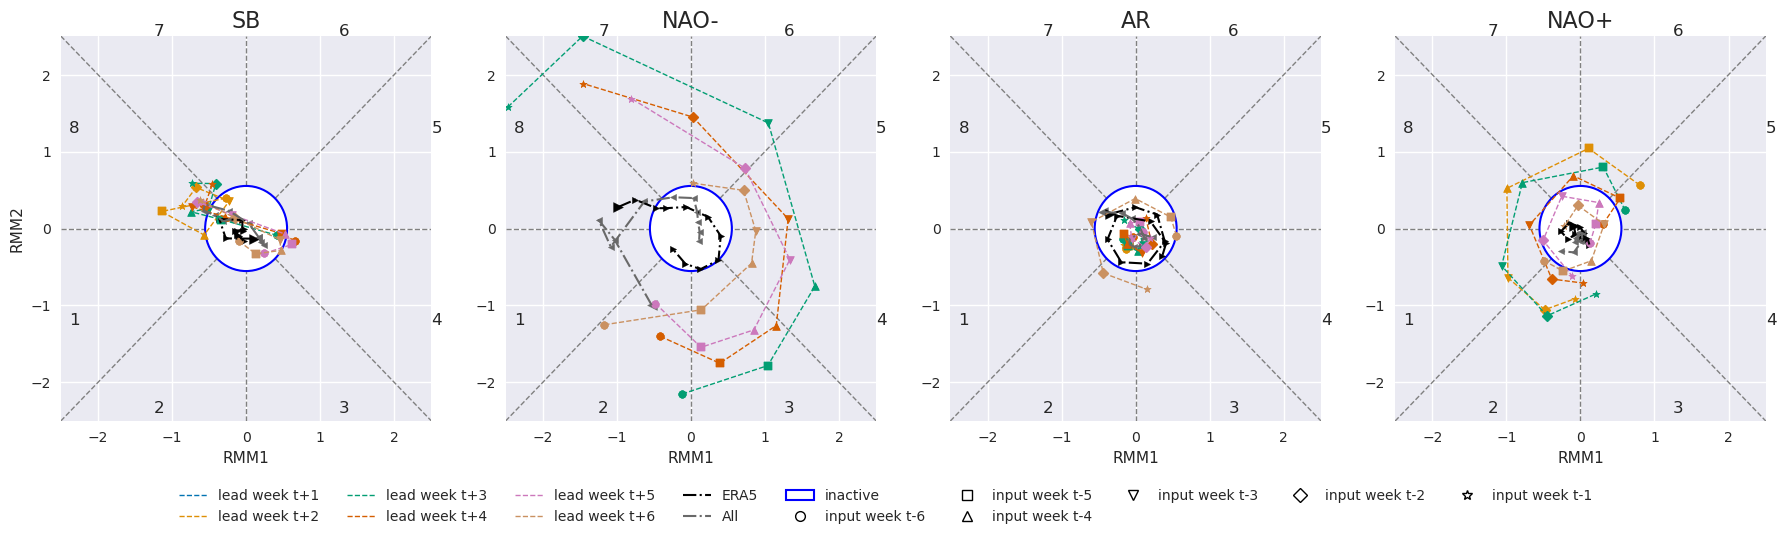

In [37]:
# PLOT MJO

from matplotlib.patches import Circle
fig, axs = plt.subplots(1, len(regimes), figsize=(22, 5))

#=========================
# 
#=========================
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.2,1, 6)
alphas_dt = np.linspace(0.2,1, rmm1_anom_all_dt_mean[r,:].shape[0])
marker_list = ["o","s","^","v","D","*"]
vmax_rmm1 = np.nanmax(np.abs(rmm1_anom_reg_dt[:,:,:].flatten()))
vmax_rmm2 = np.nanmax(np.abs(rmm2_anom_reg_dt[:,:,:].flatten()))


# amplitude_threshold = np.nanpercentile(np.abs(rmm1_anom_reg_dt[:,:,:].flatten()), 60)
np.nanmean(rmm1_anom_reg_mean) + np.nanstd(rmm1_anom_reg_mean) # 1 std above the mean of the anomalies
mjo_categories = ["phase1", "phase2","phase3","phase4","phase5","phase6","phase7","phase8", "inactive"]

labels_col = []
#====================================================
# plot 1 - MJO Phase Diagram
#====================================================
for r, reg in enumerate(regimes):
    axs[r].set_title(f"{reg}", fontsize = 16)

    plot_rmm1 = rmm1_anom_reg_mean[r,:,:]
    plot_rmm2 = rmm2_anom_reg_mean[r,:,:]

    plot_all_rmm1 = rmm1_anom_all_dt_mean[r,:]
    plot_all_rmm2 = rmm2_anom_all_dt_mean[r,:]

    plot_tar_rmm1 = rmm1_anom_tar_dt_mean[r,:]
    plot_tar_rmm2 = rmm2_anom_tar_dt_mean[r,:]

    for dt in range(plot_tar_rmm1.shape[0]):
        if dt == 0:
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = 'dimgray',#label = f'All, dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = '>',  color = 'black',#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                        s = 50, zorder = 3)
        else:
            axs[r].scatter(plot_all_rmm1[dt], plot_all_rmm2[dt], marker = '<',  color = 'dimgray',#label = f'All, dt {dt+1}', alpha =alphas[k])
                            s = 20, zorder = 3)
            axs[r].scatter(plot_tar_rmm1[dt], plot_tar_rmm2[dt], marker = '>',  color = 'black',#label = f'ERA 5 dt {dt+1}', alpha =alphas[k])
                            s = 20, zorder = 3)

    for t in range(plot_rmm1.shape[0]):
            
        for k in range(plot_rmm2.shape[1]):
            if t == 0 and r==0:
                labels_col.append(f'input week t{k-6}')
            axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = marker_list[k], color = colors[t],#alpha =alphas[k])
                           s = 30, zorder = 3)
            axs[r].scatter(plot_rmm1[t,k], plot_rmm2[t,k], marker = marker_list[k], color = colors[t],#alpha =alphas[k])
                           s = 30, zorder = 3)

        axs[r].plot(plot_rmm1[t,:], plot_rmm2[t,:], color=colors[t], label = f'lead week t+{t+1}', #marker = marker_list[t], markersize = 5, #alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder = 3)
    axs[r].plot(plot_tar_rmm1, plot_tar_rmm2, color = 'black', label = 'ERA5', linestyle = '-.',#alpha =alphas[k])
                        linewidth=1.5, zorder = 3)
    axs[r].plot(plot_all_rmm1, plot_all_rmm2, color = 'dimgray', label = 'All', linestyle = '-.',#alpha =alphas[k])
                        linewidth=1.5, zorder = 3)

    # Set axis labels and limits
    axs[r].set_xlabel('RMM1')
    # axs[r].set_ylabel('RMM2')

    # Add a white circle with radius 0.5
    circlea = Circle((0, 0), radius=amplitude_threshold, edgecolor='blue', facecolor='white', zorder = 2)
    circleb = Circle((0, 0), radius=amplitude_threshold, edgecolor='blue',linewidth=1.5 , fill = False, zorder = 2, label = 'inactive')
    axs[r].add_patch(circlea)
    axs[r].add_patch(circleb)


    # Add lines to divide each quadrant and its diagonal
    axs[r].axhline(y=0, color='gray', linestyle='--', linewidth=1, zorder = 1)
    axs[r].axvline(x=0, color='gray', linestyle='--', linewidth=1, zorder = 1)

    axs[r].plot([-vmax_rmm1, vmax_rmm1], [vmax_rmm2, -vmax_rmm2], color='gray', linestyle='--', linewidth=1, zorder = 1)
    axs[r].plot([-vmax_rmm1, vmax_rmm1], [-vmax_rmm2, vmax_rmm2], color='gray', linestyle='--', linewidth=1, zorder = 1)

    # center of 8th.
    x_3rd3 =  vmax_rmm1/2 +vmax_rmm1/4
    x_half = vmax_rmm1/2
    y_3rd3 = vmax_rmm2/2 + vmax_rmm2/4
    y_half = vmax_rmm2/2
    axs[r].text(-vmax_rmm1+0.11, -y_half, '1', fontsize=12)
    axs[r].text(-x_half, -vmax_rmm2+0.11, '2', fontsize=12)
    axs[r].text(x_half, -vmax_rmm2+0.11, '3', fontsize=12)
    axs[r].text(vmax_rmm1, -y_half, '4', fontsize=12)
    axs[r].text(vmax_rmm1, y_half, '5', fontsize=12)
    axs[r].text(x_half, vmax_rmm2, '6', fontsize=12)
    axs[r].text(-x_half, vmax_rmm2, '7', fontsize=12)
    axs[r].text(-vmax_rmm1+0.11, y_half, '8', fontsize=12)

    axs[r].set_xlim([-vmax_rmm1, vmax_rmm1])
    axs[r].set_ylim([-vmax_rmm2, vmax_rmm2])

    # Add a grid
    axs[0].grid()

f = lambda m,c: plt.plot([],[],marker=m, markeredgecolor=c, markeredgewidth=1, markerfacecolor="white", ls="none")[0]
axs[0].set_ylabel('RMM2')
handles_row, labels_row = axs[0].get_legend_handles_labels()
handles_row += [f(marker_list[i], "black") for i in range(len(marker_list))]
fig.legend(handles_row, labels_row + labels_col, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=9)
fig.savefig(f"{results_directory}/MJO_phase_{arch_type}_90thpercentile_V3.png", dpi=600, bbox_inches='tight')

# OLR Maps

In [38]:
## Climatology and anomalies of spv index
if arch_type == 'ViT':
    regimes = ['SB', 'NAO-', 'AR', 'NAO+']

    sum_u10_reg = np.zeros((len(regimes),loop_u10.shape[3],loop_u10.shape[4]))
    cnt_reg = np.zeros((len(regimes)))
    sum_sst_reg = np.zeros((len(regimes), loop_sst.shape[3],loop_sst.shape[4]))


    for i in range(loop_probabilities.shape[0]):
        for j in range(loop_probabilities.shape[1]):
            for k in range(loop_probabilities.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                    for t in range(pv_inputs.shape[2]):
                        if not np.isnan(pv_inputs[i,j,t]):
                            sum_u10_reg[loop_targets[i,j,k], :,:] += loop_u10[i,j,t,:,:]
                            cnt_reg[loop_targets[i,j,k]] +=1
                            sum_sst_reg[loop_targets[i,j,k],:,:] += loop_sst[i,j,t,:,:]

    avg_u10_reg = sum_u10_reg/np.repeat(np.repeat(cnt_reg[:,None],loop_u10.shape[3], axis =1)[:,:,None],loop_u10.shape[4], axis =2)
    avg_sst_reg = sum_sst_reg/np.repeat(np.repeat(cnt_reg[:,None],loop_u10.shape[3], axis =1)[:,:,None],loop_u10.shape[4], axis =2)


    t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]
    # pv_reg_dt = np.zeros((4,t_in +t_out-1))
    sum_spv_img = np.zeros((len(regimes), t_in +t_out-1,loop_u10.shape[3],loop_u10.shape[4]))
    cnt_reg_lag = np.zeros((len(regimes), t_in +t_out-1))
    sum_sst_img = np.zeros((len(regimes), t_in +t_out-1,loop_sst.shape[3],loop_sst.shape[4]))
    sum_spv_anom = np.zeros((len(regimes), t_in +t_out-1,loop_u10.shape[3],loop_u10.shape[4]))
    sum_sst_anom = np.zeros((len(regimes), t_in +t_out-1,loop_sst.shape[3],loop_sst.shape[4]))




    for i in range(loop_probabilities.shape[0]):
        for j in range(loop_probabilities.shape[1]):
            for k in range(loop_probabilities.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:  
                    for t in range(pv_inputs.shape[2]):
                        if not np.isnan(pv_inputs[i,j,t]):
                            d_t = np.abs((t-5)) + (k+1)
                            sum_spv_anom[loop_targets[i,j,k], d_t-1,:,:] += loop_u10[i,j,t,:,:] - avg_u10_reg[loop_targets[i,j,k],:,:]
                            cnt_reg_lag[loop_targets[i,j,k],d_t-1] +=1
                            sum_sst_anom[loop_targets[i,j,k], d_t-1,:,:] += loop_sst[i,j,t,:,:] - avg_sst_reg[loop_targets[i,j,k],:,:]
                            sum_spv_img[loop_targets[i,j,k], d_t-1,:,:] += loop_u10[i,j,t,:,:]
                            sum_sst_img[loop_targets[i,j,k], d_t-1,:,:] += loop_sst[i,j,t,:,:]

    avg_u10_anom = sum_spv_anom/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)
    avg_sst_anom = sum_sst_anom/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)
    avg_u10_img = sum_spv_img/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)
    avg_sst_img = sum_sst_img/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)


In [39]:
# Image Plots: SST
if arch_type == 'ViT':

    sst_grid = xr.open_dataarray('/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/ERA5/datasets/olr__1.40625deg_1980-2023_mjo_2d.nc')
    sst_samp = sst_grid.isel(time = 1).values
    # sst_samp[sst_samp > 0] = 1.
    # sst_samp[sst_samp < 0] = 1.
    # sst_samp[sst_samp == 0] = np.nan


    proj = ccrs.PlateCarree()
    fig, axes = plt.subplots( loop_probabilities.shape[2]*2-1, len(regimes), figsize=(18,9),
                            sharex = True, sharey = True, subplot_kw={'projection': proj})

    lead_time = np.arange(-6,6)
    extent = (sst_grid.lon.min(), sst_grid.lon.max(), sst_grid.lat.min(), sst_grid.lat.max())


    ds_sst = xr.DataArray(
        data=np.array(avg_sst_anom),
        dims=['regimes', 'leadtime','lat', 'lon'],
        coords=dict(
            lat = sst_grid.lat.values,
            lon= sst_grid.lon.values, 
            leadtime=delta_t,
            regimes = regimes,
        ),
    )

    for r, reg in enumerate(regimes):
        for i in range(len(delta_t)):

            if i >=0:
                ax = axes[i,r]
                # ds_plot = xr.where(sst_samp, np.nan, ds_sst.isel(leadtime=i).sel(regimes = reg))
                ds_plot = ds_sst[r,i,:,:]#*sst_samp


                g = ax.imshow(ds_plot, extent=extent, origin='lower', cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
                ax.coastlines()
                ax.set_extent([sst_grid.lon.min(), sst_grid.lon.max(), sst_grid.lat.min(), sst_grid.lat.max()], ccrs.PlateCarree())

                if i == 0:
                    ax.set_title(f'{reg}', fontsize=16)

    # Add column annotations for delta_t
    for i in range(len(delta_t)):
        if i == 0:
            axes[i, 0].annotate(f'{delta_t[i]} week\n', xy=(-0.3, -0.45), xycoords='axes fraction', ha='center', 
                                fontsize=16,)#rotation=90)
        else:
            axes[i, 0].annotate(f'{delta_t[i]} weeks\n', xy=(-0.3, -0.45), xycoords='axes fraction', ha='center', 
                                fontsize=16,) #rotation=90)
            
    # add space for colour bar
    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(g, cax=cbar_ax, shrink=0.8)
    cbar.set_label('anomalies', fontsize=16)

    fig.savefig(f"{results_directory}/leadtime_{arch_type}_regime_anomaliesOLR.png", dpi=600, bbox_inches='tight')


In [40]:
# Image Plots: SST
if arch_type == 'ViT':

    sst_grid = xr.open_dataarray('/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/ERA5/datasets/olr__1.40625deg_1980-2023_mjo_2d.nc')
    sst_samp = sst_grid.isel(time = 1).values
    # sst_samp[sst_samp > 0] = 1.
    # sst_samp[sst_samp < 0] = 1.
    # sst_samp[sst_samp == 0] = np.nan


    proj = ccrs.PlateCarree()
    fig, axes = plt.subplots( loop_probabilities.shape[2]*2-1, len(regimes), figsize=(18,12),
                            sharex = True, sharey = True, subplot_kw={'projection': proj})

    lead_time = np.arange(-6,6)
    extent = (sst_grid.lon.min(), sst_grid.lon.max(), sst_grid.lat.min(), sst_grid.lat.max())


    ds_sst = xr.DataArray(
        data=np.array(avg_sst_img),
        dims=['regimes', 'leadtime','lat', 'lon'],
        coords=dict(
            lat = sst_grid.lat.values,
            lon= sst_grid.lon.values, 
            leadtime=delta_t,
            regimes = regimes,
        ),
    )

    for r, reg in enumerate(regimes):
        for i in range(len(delta_t)):

            if i >=0:
                ax = axes[i,r]
                # ds_plot = xr.where(sst_samp, np.nan, ds_sst.isel(leadtime=i).sel(regimes = reg))
                ds_plot = ds_sst[r,i,:,:]#*sst_samp


                g = ax.imshow(ds_plot, extent=extent, origin='lower', cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
                ax.coastlines()
                ax.set_extent([sst_grid.lon.min(), sst_grid.lon.max(), sst_grid.lat.min(), sst_grid.lat.max()], ccrs.PlateCarree())

                if i == 0:
                    ax.set_title(f'{reg}')

    # Add column annotations for delta_t
    for i in range(len(delta_t)):
        if i == 0:
            axes[i, 0].annotate(f'{delta_t[i]} week\n', xy=(-0.13, -0.3), xycoords='axes fraction', ha='center', 
                                fontsize=12,)#rotation=90)
        else:
            axes[i, 0].annotate(f'{delta_t[i]} weeks\n', xy=(-0.13, -0.3), xycoords='axes fraction', ha='center', 
                                fontsize=12,) #rotation=90)
            
    # add space for colour bar
    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(g, cax=cbar_ax)

    fig.savefig(f"{results_directory}/leadtime_{arch_type}_regime_OLR.png", dpi=600, bbox_inches='tight')
